# Linear Congruential Generator (LCG)

## Introduction

The **Linear Congruential Generator (LCG)** is one of the oldest and most well-known algorithms for generating pseudorandom numbers. First introduced by D.H. Lehmer in 1949, it remains a cornerstone in the study of random number generation due to its simplicity and mathematical tractability.

## Mathematical Foundation

### The Recurrence Relation

An LCG generates a sequence of pseudorandom integers $X_1, X_2, X_3, \ldots$ using the following recurrence relation:

$$X_{n+1} = (a \cdot X_n + c) \mod m$$

where:
- $X_n$ is the current state (or seed for $n=0$)
- $a$ is the **multiplier** ($0 < a < m$)
- $c$ is the **increment** ($0 \leq c < m$)
- $m$ is the **modulus** ($m > 0$)

### Period and Full Period Conditions

The sequence generated by an LCG is periodic with period $T \leq m$. The LCG achieves its **maximum period** $T = m$ (called a *full period*) if and only if:

1. $\gcd(c, m) = 1$ (c and m are coprime)
2. $a - 1$ is divisible by all prime factors of $m$
3. If $m$ is divisible by 4, then $a - 1$ must also be divisible by 4

### Normalized Output

To obtain uniformly distributed random numbers in $[0, 1)$, we normalize:

$$U_n = \frac{X_n}{m}$$

## Statistical Properties

### Spectral Test

The quality of an LCG can be assessed using the **spectral test**, which examines the lattice structure of points in $d$-dimensional space:

$$(U_n, U_{n+1}, \ldots, U_{n+d-1})$$

For LCGs, these points lie on a finite number of hyperplanes, and the maximum distance between adjacent hyperplanes determines the quality.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility in comparisons
np.random.seed(42)

## Implementation

### Basic LCG Class

We implement a flexible LCG class that supports different parameter choices:

In [2]:
class LinearCongruentialGenerator:
    """
    Linear Congruential Generator for pseudorandom number generation.
    
    X_{n+1} = (a * X_n + c) mod m
    """
    
    def __init__(self, seed=1, a=1103515245, c=12345, m=2**31):
        """
        Initialize the LCG with parameters.
        
        Default parameters are from the glibc implementation.
        
        Parameters:
        -----------
        seed : int
            Initial seed value X_0
        a : int
            Multiplier
        c : int
            Increment
        m : int
            Modulus
        """
        self.a = a
        self.c = c
        self.m = m
        self.state = seed
        self.initial_seed = seed
    
    def next_int(self):
        """Generate the next integer in the sequence."""
        self.state = (self.a * self.state + self.c) % self.m
        return self.state
    
    def next_float(self):
        """Generate a random float in [0, 1)."""
        return self.next_int() / self.m
    
    def generate_sequence(self, n):
        """Generate n random floats in [0, 1)."""
        return np.array([self.next_float() for _ in range(n)])
    
    def reset(self):
        """Reset the generator to its initial seed."""
        self.state = self.initial_seed
    
    def find_period(self, max_iter=10**7):
        """Find the period of the generator."""
        self.reset()
        initial = self.next_int()
        period = 1
        
        while period < max_iter:
            if self.next_int() == initial:
                break
            period += 1
        
        self.reset()
        return period if period < max_iter else None

## Analysis of Different LCG Parameters

We'll examine several well-known LCG parameter sets used in different systems:

In [3]:
# Famous LCG parameters from various implementations
lcg_params = {
    'MINSTD': {'a': 16807, 'c': 0, 'm': 2**31 - 1},
    'glibc': {'a': 1103515245, 'c': 12345, 'm': 2**31},
    'Numerical Recipes': {'a': 1664525, 'c': 1013904223, 'm': 2**32},
    'RANDU (IBM)': {'a': 65539, 'c': 0, 'm': 2**31},  # Historically poor
}

print("LCG Parameter Configurations:")
print("=" * 60)
for name, params in lcg_params.items():
    print(f"\n{name}:")
    print(f"  a = {params['a']:,}")
    print(f"  c = {params['c']:,}")
    print(f"  m = {params['m']:,} (2^{int(np.log2(params['m']))} {'- 1' if params['m'] == 2**31-1 else ''})")

LCG Parameter Configurations:

MINSTD:
  a = 16,807
  c = 0
  m = 2,147,483,647 (2^30 - 1)

glibc:
  a = 1,103,515,245
  c = 12,345
  m = 2,147,483,648 (2^31 )

Numerical Recipes:
  a = 1,664,525
  c = 1,013,904,223
  m = 4,294,967,296 (2^32 )

RANDU (IBM):
  a = 65,539
  c = 0
  m = 2,147,483,648 (2^31 )


## Visualization of LCG Properties

### 1. Sequence Distribution

First, let's examine the distribution of generated values:

In [4]:
# Generate sequences from different LCGs
n_samples = 10000
seed = 12345

sequences = {}
for name, params in lcg_params.items():
    lcg = LinearCongruentialGenerator(seed=seed, **params)
    sequences[name] = lcg.generate_sequence(n_samples)

### 2. Lattice Structure Visualization

One of the most important tests for LCG quality is examining the lattice structure of consecutive pairs $(U_n, U_{n+1})$. Poor LCGs exhibit visible patterns:

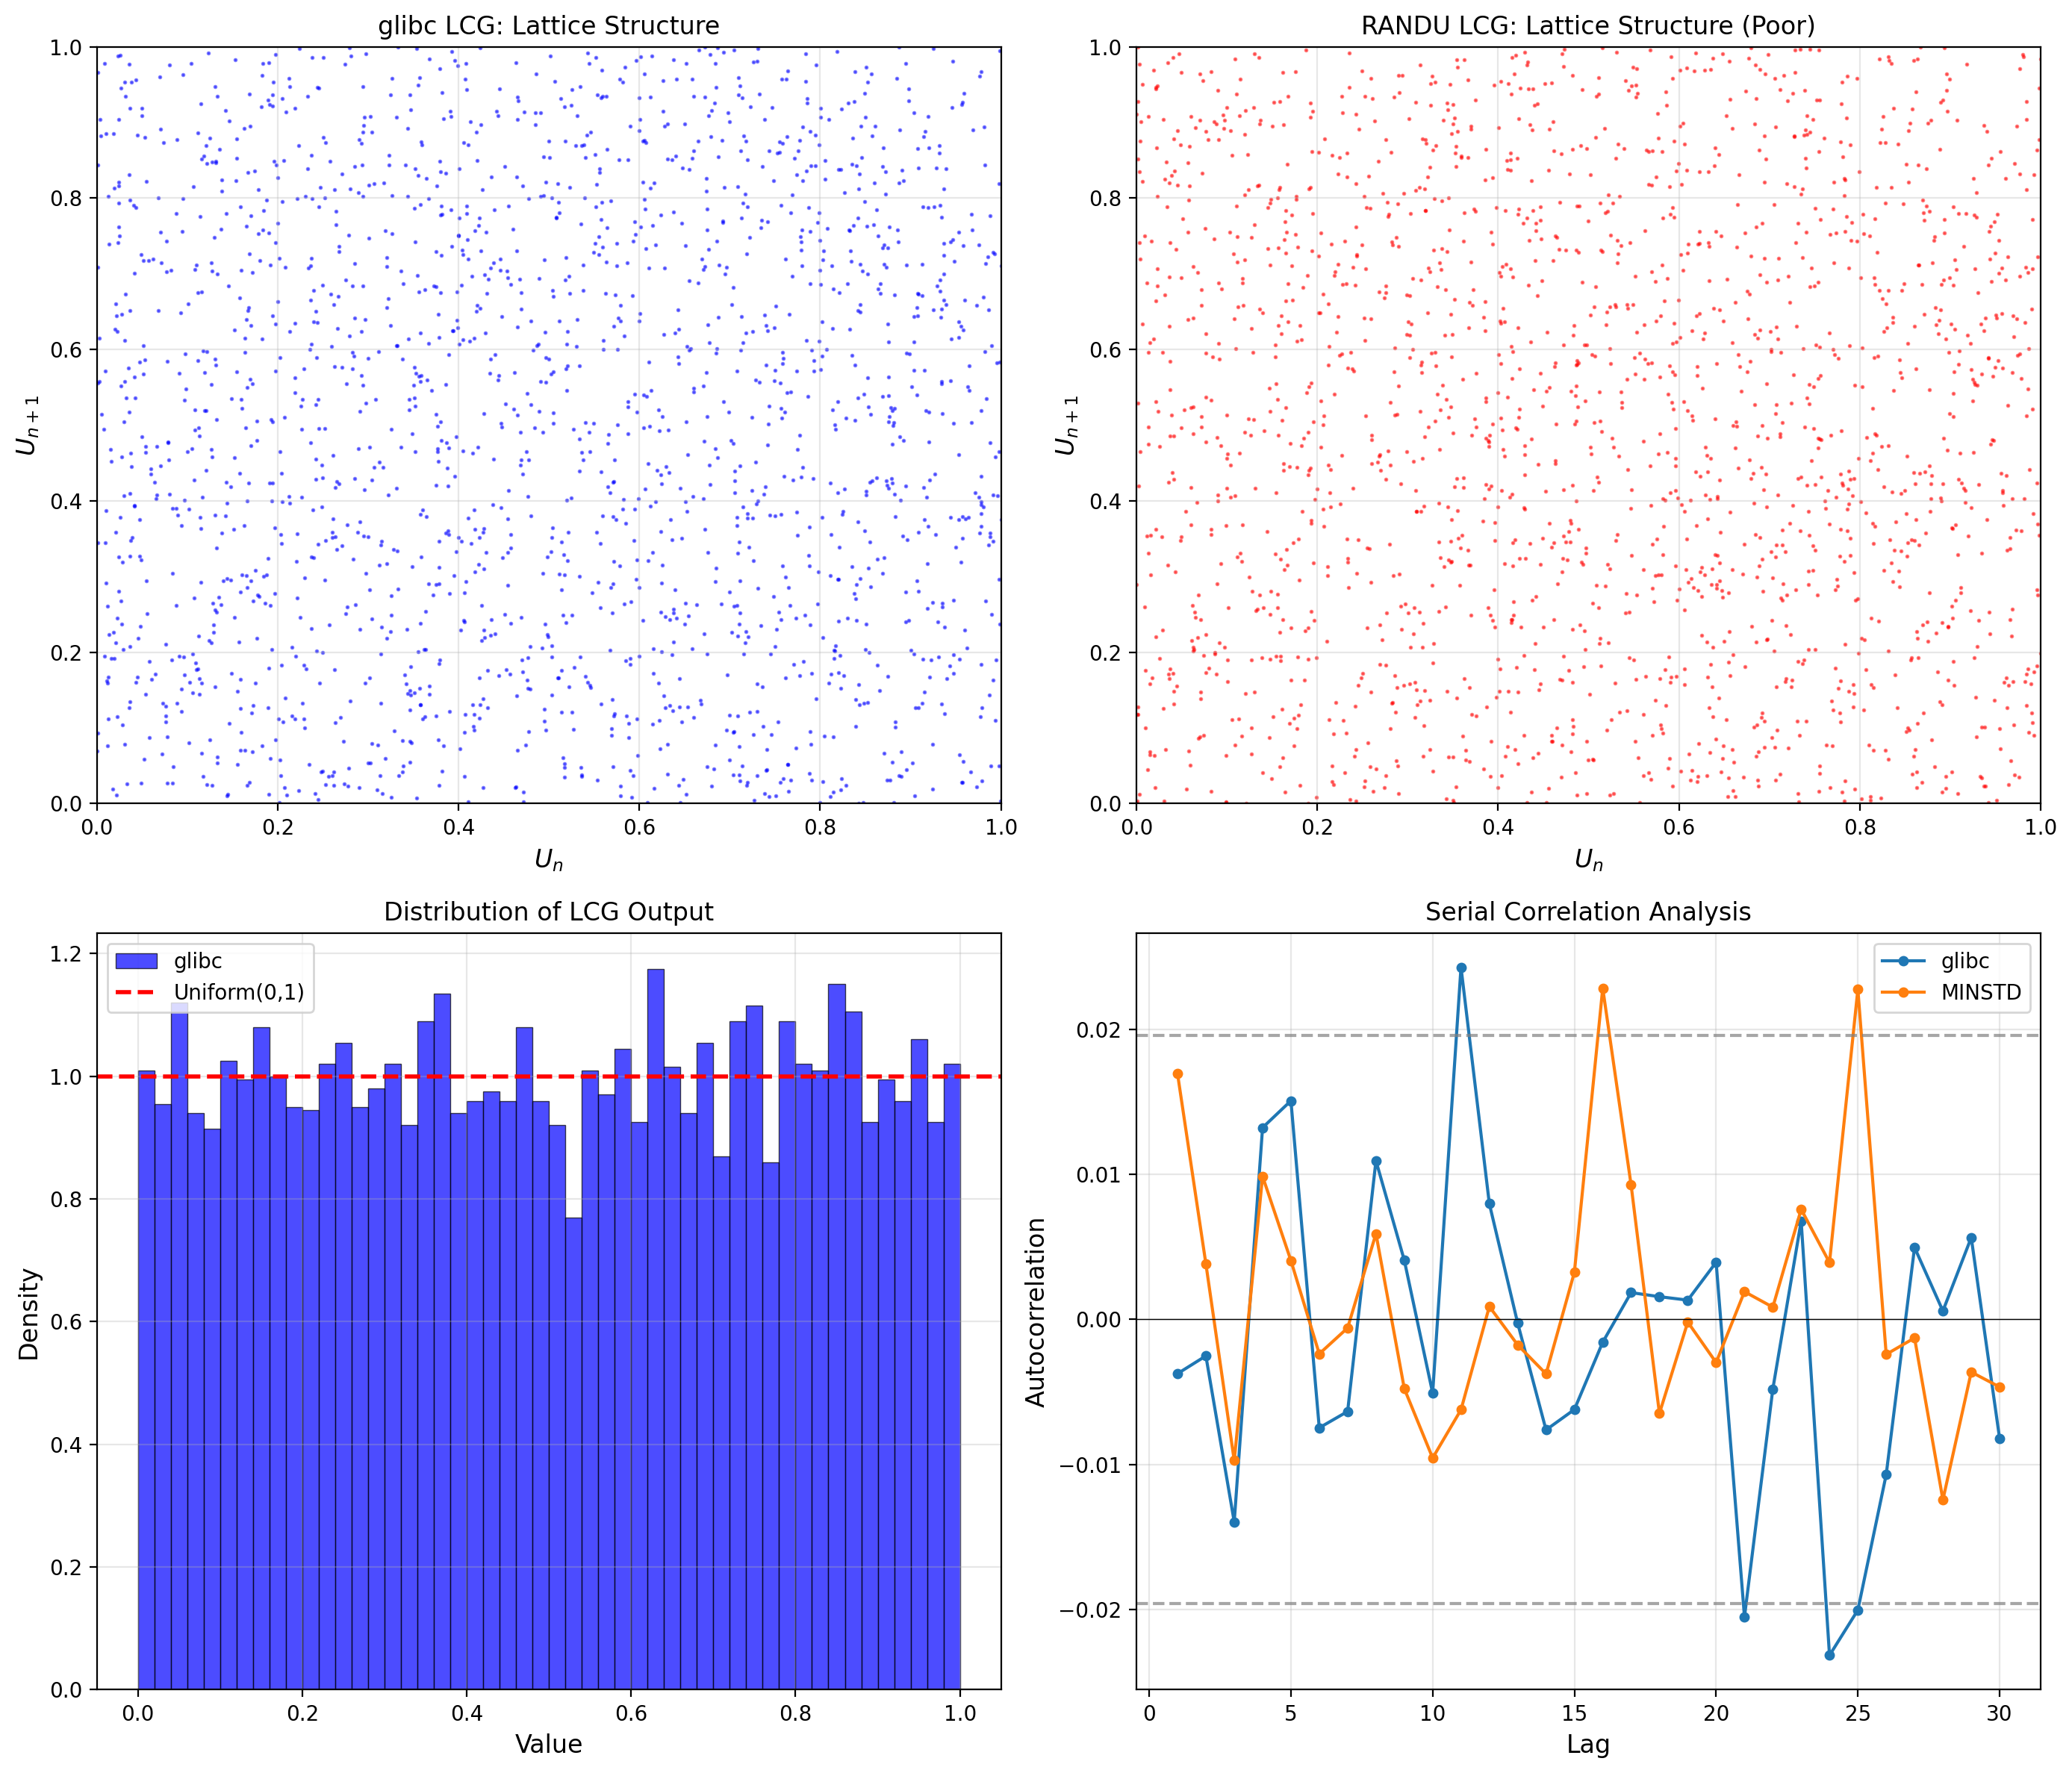


Plot saved to 'plot.png'


In [5]:
# Create comprehensive visualization
fig = plt.figure(figsize=(14, 12))

# Plot 1: Lattice structure (2D scatter of consecutive pairs)
ax1 = fig.add_subplot(2, 2, 1)
lcg_glibc = LinearCongruentialGenerator(seed=1, **lcg_params['glibc'])
seq_glibc = lcg_glibc.generate_sequence(2000)
ax1.scatter(seq_glibc[:-1], seq_glibc[1:], alpha=0.5, s=1, c='blue')
ax1.set_xlabel(r'$U_n$', fontsize=12)
ax1.set_ylabel(r'$U_{n+1}$', fontsize=12)
ax1.set_title('glibc LCG: Lattice Structure', fontsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# Plot 2: RANDU lattice (known to be poor)
ax2 = fig.add_subplot(2, 2, 2)
lcg_randu = LinearCongruentialGenerator(seed=1, **lcg_params['RANDU (IBM)'])
seq_randu = lcg_randu.generate_sequence(2000)
ax2.scatter(seq_randu[:-1], seq_randu[1:], alpha=0.5, s=1, c='red')
ax2.set_xlabel(r'$U_n$', fontsize=12)
ax2.set_ylabel(r'$U_{n+1}$', fontsize=12)
ax2.set_title('RANDU LCG: Lattice Structure (Poor)', fontsize=12)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

# Plot 3: Histogram comparison
ax3 = fig.add_subplot(2, 2, 3)
ax3.hist(sequences['glibc'], bins=50, density=True, alpha=0.7, 
         label='glibc', color='blue', edgecolor='black', linewidth=0.5)
ax3.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Uniform(0,1)')
ax3.set_xlabel('Value', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title('Distribution of LCG Output', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Autocorrelation analysis
ax4 = fig.add_subplot(2, 2, 4)
max_lag = 30
lags = np.arange(1, max_lag + 1)

for name, seq in [('glibc', sequences['glibc']), ('MINSTD', sequences['MINSTD'])]:
    autocorr = [np.corrcoef(seq[:-lag], seq[lag:])[0, 1] for lag in lags]
    ax4.plot(lags, autocorr, 'o-', label=name, markersize=4)

# Add confidence bounds for white noise
conf_bound = 1.96 / np.sqrt(n_samples)
ax4.axhline(y=conf_bound, color='gray', linestyle='--', alpha=0.7)
ax4.axhline(y=-conf_bound, color='gray', linestyle='--', alpha=0.7)
ax4.axhline(y=0, color='black', linewidth=0.5)

ax4.set_xlabel('Lag', fontsize=12)
ax4.set_ylabel('Autocorrelation', fontsize=12)
ax4.set_title('Serial Correlation Analysis', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('random_number_generator_lcg_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Statistical Testing

### Kolmogorov-Smirnov Test

We test the null hypothesis that the generated samples come from a uniform distribution $U(0,1)$:

In [6]:
print("Kolmogorov-Smirnov Test Results:")
print("=" * 50)
print(f"{'Generator':<20} {'KS Statistic':<15} {'p-value':<15}")
print("-" * 50)

for name, seq in sequences.items():
    ks_stat, p_value = stats.kstest(seq, 'uniform')
    print(f"{name:<20} {ks_stat:<15.6f} {p_value:<15.6f}")

print("\nNote: p-value > 0.05 indicates failure to reject uniformity.")

Kolmogorov-Smirnov Test Results:
Generator            KS Statistic    p-value        
--------------------------------------------------
MINSTD               0.006686        0.759958       
glibc                0.008090        0.526958       
Numerical Recipes    0.005960        0.867344       
RANDU (IBM)          0.006231        0.829884       

Note: p-value > 0.05 indicates failure to reject uniformity.


### Chi-Square Test

We also perform a chi-square goodness-of-fit test by binning the data:

In [7]:
n_bins = 20
expected_freq = n_samples / n_bins

print("\nChi-Square Goodness-of-Fit Test:")
print("=" * 50)
print(f"{'Generator':<20} {'Chi² Statistic':<15} {'p-value':<15}")
print("-" * 50)

for name, seq in sequences.items():
    observed, _ = np.histogram(seq, bins=n_bins, range=(0, 1))
    chi2_stat, p_value = stats.chisquare(observed, f_exp=np.full(n_bins, expected_freq))
    print(f"{name:<20} {chi2_stat:<15.4f} {p_value:<15.6f}")


Chi-Square Goodness-of-Fit Test:
Generator            Chi² Statistic  p-value        
--------------------------------------------------
MINSTD               14.9720         0.724375       
glibc                15.5680         0.685878       
Numerical Recipes    24.0800         0.193102       
RANDU (IBM)          14.3040         0.765690       


## The RANDU Problem: A Cautionary Tale

The RANDU generator, developed by IBM in the 1960s, is a notorious example of a poor LCG. Its parameters:

$$X_{n+1} = 65539 \cdot X_n \mod 2^{31}$$

While it passes 1D and 2D tests, it fails spectacularly in 3D due to the relationship:

$$X_{n+2} = 6 \cdot X_{n+1} - 9 \cdot X_n \mod 2^{31}$$

This means all points $(X_n, X_{n+1}, X_{n+2})$ lie on just 15 planes!

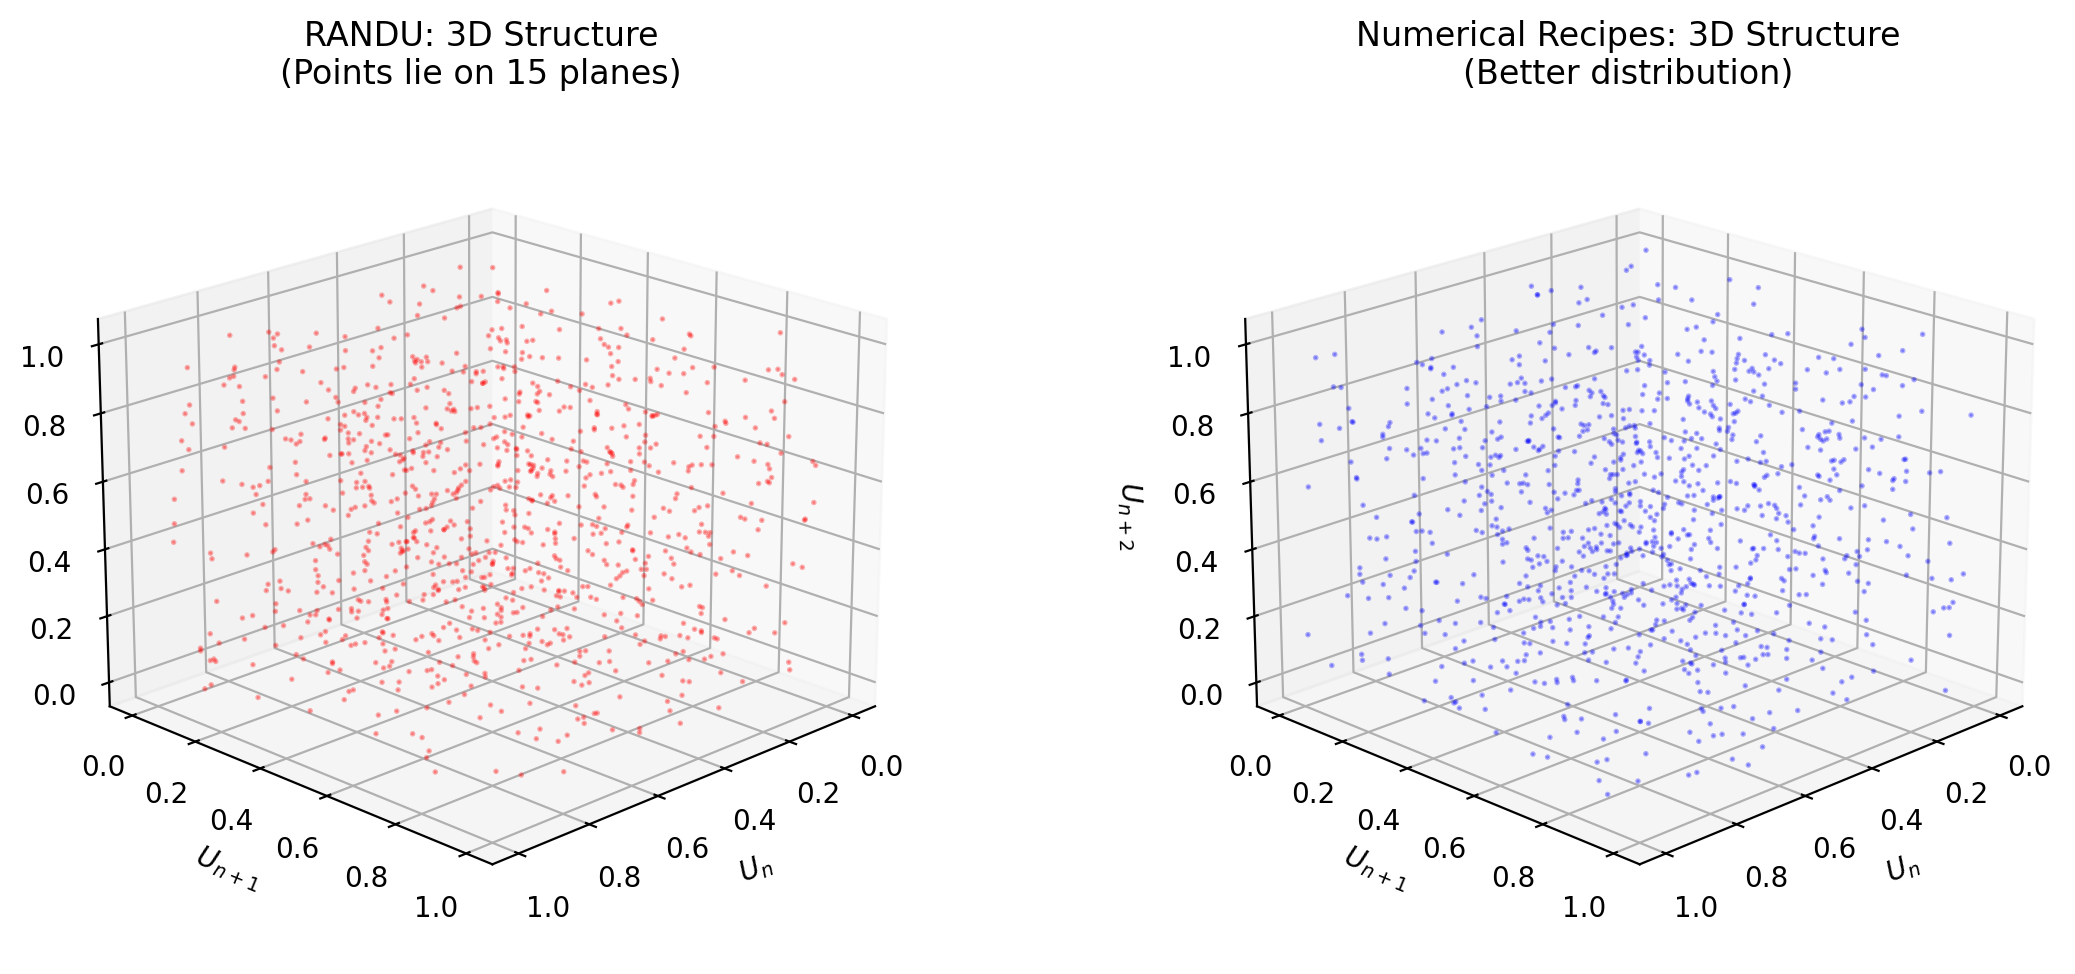

In [8]:
# Demonstrate RANDU's 3D failure
lcg_randu = LinearCongruentialGenerator(seed=1, **lcg_params['RANDU (IBM)'])
n_points = 5000
randu_seq = lcg_randu.generate_sequence(n_points + 2)

# Create 3D points from consecutive triples
x = randu_seq[:-2]
y = randu_seq[1:-1]
z = randu_seq[2:]

# 3D visualization
fig = plt.figure(figsize=(12, 5))

# RANDU 3D plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x[:1000], y[:1000], z[:1000], alpha=0.3, s=1, c='red')
ax1.set_xlabel(r'$U_n$')
ax1.set_ylabel(r'$U_{n+1}$')
ax1.set_zlabel(r'$U_{n+2}$')
ax1.set_title('RANDU: 3D Structure\n(Points lie on 15 planes)')
ax1.view_init(elev=20, azim=45)

# Compare with good LCG
lcg_nr = LinearCongruentialGenerator(seed=1, **lcg_params['Numerical Recipes'])
nr_seq = lcg_nr.generate_sequence(n_points + 2)
x2, y2, z2 = nr_seq[:-2], nr_seq[1:-1], nr_seq[2:]

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x2[:1000], y2[:1000], z2[:1000], alpha=0.3, s=1, c='blue')
ax2.set_xlabel(r'$U_n$')
ax2.set_ylabel(r'$U_{n+1}$')
ax2.set_zlabel(r'$U_{n+2}$')
ax2.set_title('Numerical Recipes: 3D Structure\n(Better distribution)')
ax2.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

## Monte Carlo Application: Estimating π

We demonstrate the practical use of our LCG by estimating $\pi$ using Monte Carlo integration.

The probability that a random point $(x, y) \in [0, 1]^2$ falls inside a quarter circle of radius 1 is:

$$P = \frac{\text{Area of quarter circle}}{\text{Area of square}} = \frac{\pi/4}{1} = \frac{\pi}{4}$$

Therefore: $\pi \approx 4 \times \frac{\text{points inside}}{\text{total points}}$

In [9]:
def estimate_pi(lcg, n_points):
    """Estimate π using Monte Carlo method with given LCG."""
    inside = 0
    for _ in range(n_points):
        x = lcg.next_float()
        y = lcg.next_float()
        if x*x + y*y <= 1:
            inside += 1
    return 4 * inside / n_points

# Estimate π with different generators
n_mc = 100000

print("Monte Carlo Estimation of π:")
print("=" * 50)
print(f"{'Generator':<20} {'Estimate':<15} {'Error':<15}")
print("-" * 50)

for name, params in lcg_params.items():
    lcg = LinearCongruentialGenerator(seed=42, **params)
    pi_est = estimate_pi(lcg, n_mc)
    error = abs(pi_est - np.pi)
    print(f"{name:<20} {pi_est:<15.8f} {error:<15.8f}")

print(f"\nTrue value: π = {np.pi:.8f}")

Monte Carlo Estimation of π:
Generator            Estimate        Error          
--------------------------------------------------
MINSTD               3.14904000      0.00744735     
glibc                3.14208000      0.00048735     
Numerical Recipes    3.14996000      0.00836735     
RANDU (IBM)          3.13968000      0.00191265     

True value: π = 3.14159265


## Conclusions

### Key Takeaways

1. **Simplicity vs Quality**: LCGs are computationally efficient but have inherent limitations in statistical quality.

2. **Parameter Selection**: The choice of $(a, c, m)$ critically affects the period and distribution properties.

3. **Lattice Structure**: All LCGs produce points that lie on hyperplanes in multi-dimensional space—this is a fundamental limitation.

4. **Testing is Essential**: A generator must be tested in the dimensions it will be used; 1D tests are insufficient.

5. **Modern Alternatives**: For serious applications, consider:
   - Mersenne Twister (period $2^{19937}-1$)
   - PCG (Permuted Congruential Generator)
   - Xoroshiro128+

### Historical Context

Despite their limitations, LCGs played a crucial role in the development of Monte Carlo methods and remain valuable for:
- Educational purposes
- Simple simulations where high-quality randomness is not critical
- Reproducible sequences with minimal state

## References

1. Lehmer, D.H. (1951). Mathematical methods in large-scale computing units. *Proceedings of the Second Symposium on Large Scale Digital Calculating Machinery*, 141-146.

2. Knuth, D.E. (1997). *The Art of Computer Programming, Volume 2: Seminumerical Algorithms* (3rd ed.). Addison-Wesley.

3. L'Ecuyer, P. (1999). Tables of linear congruential generators of different sizes and good lattice structure. *Mathematics of Computation*, 68(225), 249-260.

4. Marsaglia, G. (1968). Random numbers fall mainly in the planes. *Proceedings of the National Academy of Sciences*, 61(1), 25-28.